# The Time-Dependent Schrödinger Equation:

In [46]:
import numpy as np, matplotlib.pyplot as plt, numba
from scipy.linalg import eigh_tridiagonal
from matplotlib import animation
from numba import jit

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

The Time-Dependent Schrödinger Equaton in a position basis with infinite boundaries, is $$i\hbar\frac\partial{\partial t}\psi(\vec r,t)=-\frac{\hbar^2}{2m}\nabla^2\psi(\vec r,t)+V(\vec r)\psi(\vec r,t)$$ where $\vec r=\langle x,y,z\rangle$, with the Boundary Conditions $\psi(\vec 0,t)=\psi(\vec L,t)=0$.

Transforming this to be in $\mathbb R$, and multiplying both sides by $mL^2$ where $L$ is a characteristic length: $$imL^2\hbar\frac\partial{\partial t}(x,t)=-\frac 12\hbar^2L^2\frac{\partial^2}{\partial x^2}\psi(x,t)+mL^2V(x)\psi(x,t)$$ We choose $\hbar=1$ and make 
- $x'=x/L$
- $t'=t/mL^2$
- $V'=mL^2V$

as dimensionless quantities. The equation then becomes $$i\frac\partial{\partial t'}\psi(x',t')=-\frac 12\frac{\partial^2}{\partial x'^2}\psi(x',t')+V'(x')\psi(x',t')$$

# Technique 1 - Finite Difference Method:

We choose a discrete grid with spacing $\delta x$ and $\delta t$ and let $\psi_j^m=\psi(j\delta x,m\delta t)$ so $$i\frac{\psi_j^{m+1}-\psi_j^m}{\delta t}=-\frac 12\frac{\psi_{j+1}^m+\psi_{j-1}^m-2\psi_j^m}{\delta x^2}+V\psi_j^m$$ Rearranging: $$\psi_j^{m+1}=\psi_j^m+\frac i2\frac{\delta t}{\delta x^2}\big(\psi_{j+1}^m+\psi_{j-1}^m-2\psi_j^m\big)-i\delta tV\psi_j^m$$ Defining parameters of interest:

In [47]:
Nx = 301
Nt = 100000

dx = 1 / (Nx - 1)
dt = 1e-07

x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2) * np.sin(np.pi * x)

mu, sigma = 1 / 2, 1 / 20
V = -1e+04 * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [48]:
np.sum(np.absolute(psi0) ** 2) * dx, dt / dx ** 2

(1.0, 0.008999999999999998)

Here, $dt/dx^2$ is small enough for this method to work. The (dmensionless) potential examined here is $$V(x)=-10^4\exp\Bigg(-\frac{(x-L/2)^2}{2(L/20)^2}\Bigg)$$ 

Text(0, 0.5, '$V(x)$')

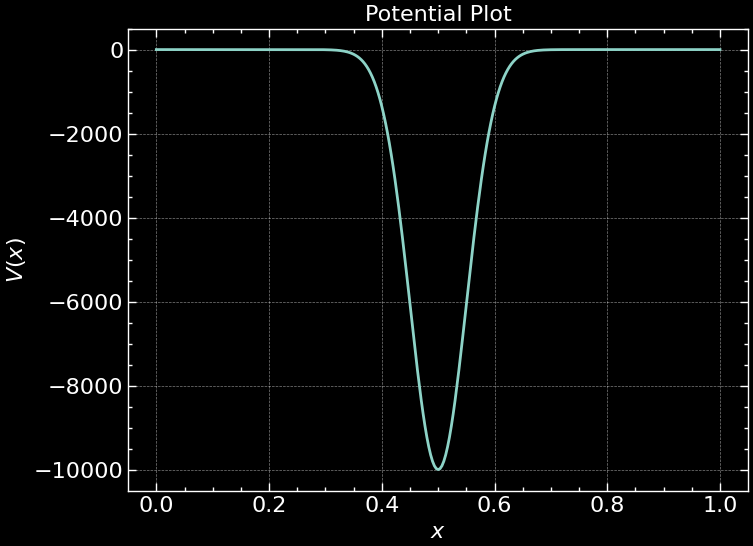

In [49]:
plt.plot(x, V)

plt.title('Potential Plot')
plt.xlabel(r'$x$')
plt.ylabel(r'$V(x)$')

We construct the 2-D $\psi(x,t)$ array:

In [50]:
psi = np.zeros([Nt, Nx])
psi[0] = psi0

In [51]:
@numba.jit('c16[:,:](c16[:,:])', nopython = True, nogil = True)
def compute_psi(psi):
    for t in range(0, Nt - 1):
        for i in range(1, Nx - 1):
            psi[t + 1][i] = psi[t][i] + 1j / 2 * dt / dx ** 2 * (psi[t][i + 1] + psi[t][i - 1] - 2 * psi[t][i]) - 1j * dt * V[i] * psi[t][i]

        normal = np.sum(np.absolute(psi[t + 1]) ** 2) * dx
        for i in range(1, Nx - 1):
            psi[t + 1][i] = psi[t + 1][i] / normal

    return psi

0.9999999995490179

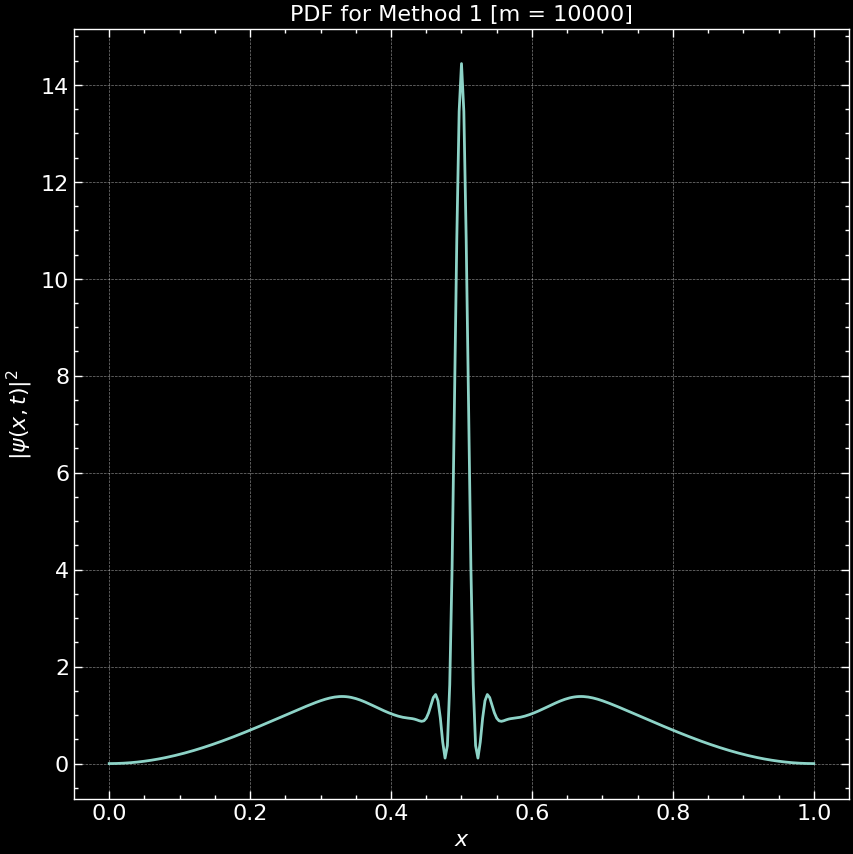

In [52]:
psi_m1 = compute_psi(psi.astype(complex))
m = 10000 # CHANGE THIS AS YOU PLEASE   

plt.figure(figsize = (10, 10))
plt.plot(x, np.absolute(psi_m1[m]) ** 2)
plt.title('PDF for Method 1 [m = {}]'.format(m))
plt.xlabel(r'$x$')
plt.ylabel('$|\psi(x,t)|^2$')

np.sum(np.absolute(psi_m1[m]) ** 2) * dx

# Technique 2 - Eigenstate Evolution: 

We have to find the $\psi_j$ and $E_j$'s that satisfy $$-\frac 12\frac{\partial^2}{\partial x^2}\psi(x,t)+V(x)\psi(x,t)=E\psi(x,t)$$ and then $$\psi(x,t)=\sum_{j=0}^\infty c_j\psi_j(x)\exp(-iE_jt)$$ where $$c_j=\int_{\mathbb R}\psi(x,0)\psi_j^*(x)\,dx$$ Let's create the grid and define the initial condition $\psi(x,0):$

In [53]:
Nx = 301
dx = 1 / (Nx - 1)

x = np.linspace(0, 1, Nx)
psi0 = np.sqrt(2) * np.sin(np.pi * x)

def V(x):
    mu, sigma = 1 / 2, 1 / 20
    return -1e+04 * np.exp(-(x - 1 / 2) ** 2 / (2 * (1 / 20) ** 2))

Let's now define the Tridiagonal Matrix for the eigenstates of the equation, compute the eigenstates $\psi_j$ and eigenenergies $E_j$:

Text(0, 0.5, '$\\psi_3$')

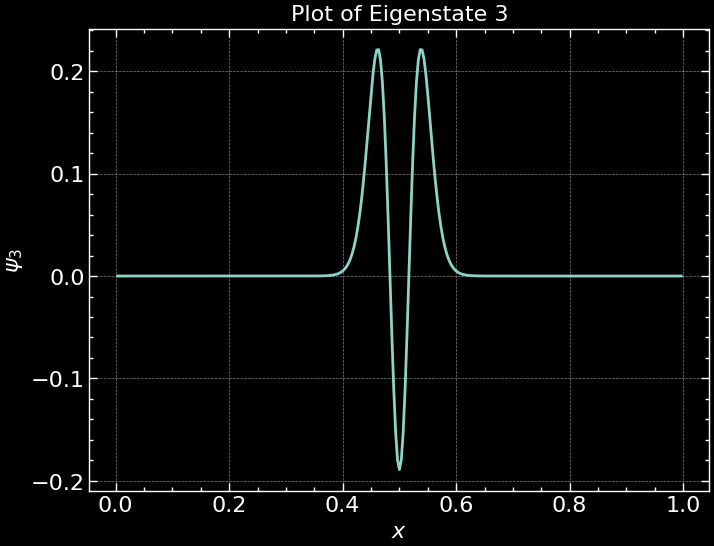

In [54]:
d = 1 / dx ** 2 + V(x)[1:-1]
e = -1 / (2 * dx ** 2) * np.ones(len(d) - 1)

w, v = eigh_tridiagonal(d, e)

eigenstate = 3 # CHANGE THIS AS YOU PLEASE
plt.plot(x[1:-1], v.T[eigenstate - 1])

plt.title(r'Plot of Eigenstate {}'.format(eigenstate))
plt.xlabel('$x$')
plt.ylabel(r'$\psi_{}$'.format(eigenstate))

In [55]:
Ej_values = w[0:70]
psij_values = np.pad(v.T[0:70], [(0, 0), (1, 1)], mode = 'constant')
c_values = np.dot(psij_values, psi0)

def psi_m2(t):
    return psij_values.T@(c_values * np.exp(-1j * Ej_values * t))

0.9999999999999927

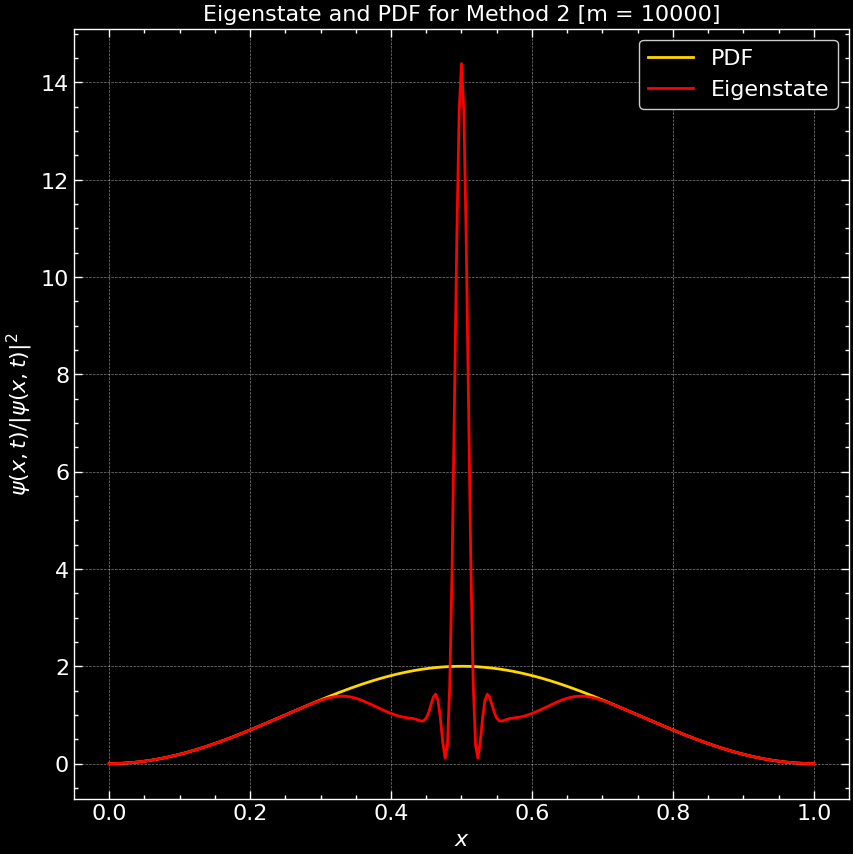

In [56]:
m = 10000 # CHANGE THIS AS YOU PLEASE

plt.figure(figsize = (10, 10))
plt.plot(x, psi0 ** 2, color = 'gold', label = 'PDF')
plt.plot(x, np.absolute(psi_m2(m * dt)) ** 2, color = 'red', label = 'Eigenstate')

plt.title('Eigenstate and PDF for Method 2 [m = {}]'.format(m))
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel('$\psi(x,t)/|\psi(x,t)|^2$')

np.sum(np.absolute(psi_m2(m)) ** 2) * dx

# Animation:

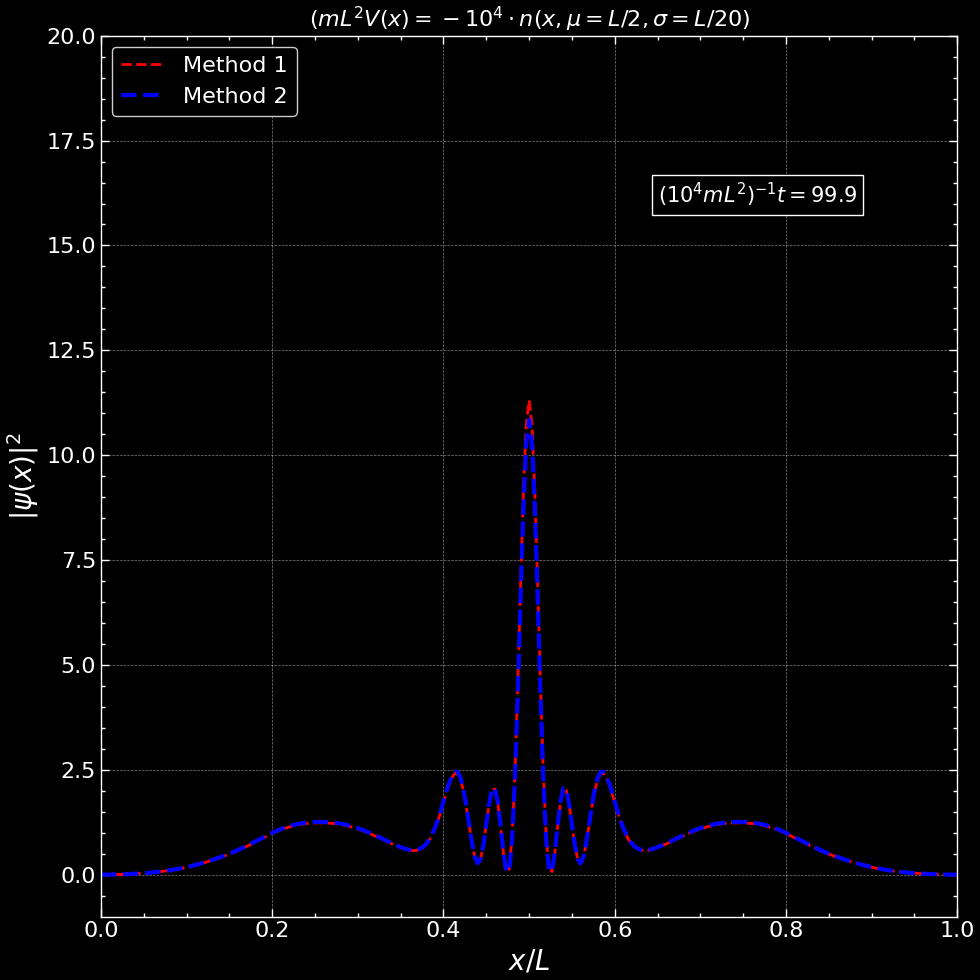

In [57]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[100 * i]) ** 2)
    ln2.set_data(x, np.absolute(psi_m2(100 * i * dt)) ** 2)

    time_text.set_text(r'$(10^4mL^2)^{-1}t=$' + r'{:.1f}'.format(100 * i * dt * 1e+04))

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ln1, = plt.plot([], [], 'r--', lw = 2, markersize = 8, label = 'Method 1')
ln2, = plt.plot([], [], 'b--', lw = 3, markersize = 8, label = 'Method 2')
time_text = ax.text(0.65, 16, '', fontsize = 15, bbox = dict(facecolor = 'black', edgecolor = 'white'))

ax.set_ylim(-1, 20)
ax.set_xlim(0, 1)

ax.set_title(r'$(mL^2V(x)=-10^4\cdot n(x,\mu=L/2,\sigma=L/20)$')
ax.legend(loc = 'upper left')
ax.set_xlabel(r'$x/L$', fontsize = 20)
ax.set_ylabel(r'$|\psi(x)|^2$', fontsize = 20)

plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames = 1000, interval = 50)
ani.save('../Outputs/schrödinger.gif', writer = 'pillow', fps = 50, dpi = 100)